In [1]:
import Pkg
Pkg.develop(path="C:/Users/Mathis/Documents/PhD/SDDP_RVI/SDDP2")

   Resolving package versions...
  No Changes to `C:\Users\Mathis\.julia\environments\v1.9\Project.toml`
  No Changes to `C:\Users\Mathis\.julia\environments\v1.9\Manifest.toml`


In [2]:
using Revise
using SDDP
using Random
using Plots
using Gurobi
using Statistics
const GRB_ENV = Gurobi.Env()
optimizer=() -> Gurobi.Optimizer(GRB_ENV)

Set parameter Username
Academic license - for non-commercial use only - expires 2026-03-17


#13 (generic function with 1 method)

In [3]:
graph=SDDP.InfiniteLinearGraph(1)

Root
 0
Nodes
 1
Arcs
 0 => 1 w.p. 1.0
 1 => 1 w.p. 1.0

In [4]:
function subproblem_builder(subproblem::Model, node::Int, discount_factor::Float64)
    # State variables
    N=1
    @variable(subproblem, 0 <= volume[1:N] <= 200, SDDP.State, initial_value = 150)
    # Control variables
    @variables(subproblem, begin
        thermal_generation[1:4] >= 0
        thermal_generation_tot >= 0
        hydro_generation[1:N] >= 0
        hydro_spill[1:N] >= 0
        deficit >= 0
    end)
    # Random variables
    @variable(subproblem, inflow)
    Ω = [50.0, 90.0]
    P = [1 / 2, 1 / 2]
    SDDP.parameterize(subproblem, Ω, P) do ω
        return JuMP.fix(inflow, ω)
    end

    capa_th = [10 15 10 5] 
    c_th = [1 2 5 10]
    # Transition function and constraints
    @constraints(
        subproblem,
        begin
            [i in 1:N], volume[i].out == volume[i].in - hydro_generation[i] - hydro_spill[i] + inflow/N
            [i in 1:N], hydro_generation[i] <= 100
            [i in 1:4], thermal_generation[i] <= capa_th[i]
            thermal_generation_tot==sum(thermal_generation[i] for i in 1:4)
            deficit + sum(hydro_generation[i] for i in 1:N) + thermal_generation_tot == 80
        end
    )
    # Stage-objective
    @stageobjective(subproblem, 20*sum(hydro_spill[i] for i in 1:N) + 50 * deficit+ sum(thermal_generation[i]*c_th[i] for i in 1:4))
    return subproblem
end

subproblem_builder (generic function with 1 method)

In [57]:
model1 = SDDP.PolicyGraph(
    subproblem_builder,
    graph;
    sense = :Min,
    lower_bound = 0.0,
    optimizer = optimizer,
    discount_factor=0.999,
)

Random.seed!(12345)

Cuts1=SDDP.train(model1; sampling_scheme=SDDP.InSampleMonteCarlo(max_depth=3*100, rollout_limit = i -> 11*i), iteration_limit = 8, infinite = true, print_level=0, cut_selection=false, shift_function=SDDP.random_shift)

Tuple{Int64, Any}[(1, 90.0), (1, 50.0), (1, 90.0), (1, 50.0), (1, 50.0), (1, 90.0), (1, 90.0), (1, 50.0), (1, 50.0), (1, 50.0), (1, 90.0)]
[Dict(Symbol("volume[1]") => 160.0), Dict(Symbol("volume[1]") => 130.0), Dict(Symbol("volume[1]") => 140.0), Dict(Symbol("volume[1]") => 110.0), Dict(Symbol("volume[1]") => 80.0), Dict(Symbol("volume[1]") => 90.0), Dict(Symbol("volume[1]") => 100.0), Dict(Symbol("volume[1]") => 70.0), Dict(Symbol("volume[1]") => 40.0), Dict(Symbol("volume[1]") => 10.0), Dict(Symbol("volume[1]") => 20.0)]
Tuple{Int64, Any}[(1, 50.0), (1, 50.0), (1, 90.0), (1, 50.0), (1, 90.0), (1, 50.0), (1, 90.0), (1, 90.0), (1, 50.0), (1, 50.0), (1, 50.0), (1, 90.0), (1, 90.0), (1, 50.0), (1, 90.0), (1, 50.0), (1, 90.0), (1, 50.0), (1, 90.0), (1, 50.0), (1, 50.0), (1, 50.0)]
[Dict(Symbol("volume[1]") => 120.0), Dict(Symbol("volume[1]") => 90.0), Dict(Symbol("volume[1]") => 100.0), Dict(Symbol("volume[1]") => 70.0), Dict(Symbol("volume[1]") => 80.0), Dict(Symbol("volume[1]") => 50.0

8-element Vector{SDDP.Log}:
 SDDP.Log(1, 0.31260036404952884, 0.0, 0.07400012016296387, 1, 35, " ", false, Dict{Int64, Vector{Any}}(1 => [(theta = 5.0, pi = Dict(Symbol("volume[1]") => -0.5), x = Dict(Symbol("volume[1]") => 20.0), obj_y = nothing, belief_y = nothing), (theta = 24.99, pi = Dict(Symbol("volume[1]") => -1.24975), x = Dict(Symbol("volume[1]") => 10.0), obj_y = nothing, belief_y = nothing), (theta = 11.24000375, pi = Dict(Symbol("volume[1]") => -0.624250125), x = Dict(Symbol("volume[1]") => 40.0), obj_y = nothing, belief_y = nothing), (theta = 5.614381873125, pi = Dict(Symbol("volume[1]") => -0.3118129374375), x = Dict(Symbol("volume[1]") => 70.0), obj_y = nothing, belief_y = nothing), (theta = 0.0, pi = Dict(Symbol("volume[1]") => 0.0), x = Dict(Symbol("volume[1]") => 100.0), obj_y = nothing, belief_y = nothing), (theta = 0.0, pi = Dict(Symbol("volume[1]") => 0.0), x = Dict(Symbol("volume[1]") => 90.0), obj_y = nothing, belief_y = nothing), (theta = 2.4962524987499997, pi 

In [58]:
model2 = SDDP.PolicyGraph(
    subproblem_builder,
    graph;
    sense = :Min,
    lower_bound = 0.0,
    optimizer = optimizer,
    discount_factor=0.98,
)

Random.seed!(12345)

Cuts2=SDDP.train(model2; sampling_scheme=SDDP.InSampleMonteCarlo(max_depth=3*100, rollout_limit = i -> 11*i), iteration_limit = 8, infinite = true, print_level=0, cut_selection=false, shift_function=SDDP.random_shift2)

Tuple{Int64, Any}[(1, 90.0), (1, 50.0), (1, 90.0), (1, 50.0), (1, 50.0), (1, 90.0), (1, 90.0), (1, 50.0), (1, 50.0), (1, 50.0), (1, 90.0)]
[Dict(Symbol("volume[1]") => 160.0), Dict(Symbol("volume[1]") => 130.0), Dict(Symbol("volume[1]") => 140.0), Dict(Symbol("volume[1]") => 110.0), Dict(Symbol("volume[1]") => 80.0), Dict(Symbol("volume[1]") => 90.0), Dict(Symbol("volume[1]") => 100.0), Dict(Symbol("volume[1]") => 70.0), Dict(Symbol("volume[1]") => 40.0), Dict(Symbol("volume[1]") => 10.0), Dict(Symbol("volume[1]") => 20.0)]
Tuple{Int64, Any}[(1, 50.0), (1, 50.0), (1, 90.0), (1, 50.0), (1, 90.0), (1, 50.0), (1, 90.0), (1, 90.0), (1, 50.0), (1, 50.0), (1, 50.0), (1, 90.0), (1, 90.0), (1, 50.0), (1, 90.0), (1, 50.0), (1, 90.0), (1, 50.0), (1, 90.0), (1, 50.0), (1, 50.0), (1, 50.0)]
[Dict(Symbol("volume[1]") => 120.0), Dict(Symbol("volume[1]") => 90.0), Dict(Symbol("volume[1]") => 100.0), Dict(Symbol("volume[1]") => 70.0), Dict(Symbol("volume[1]") => 80.0), Dict(Symbol("volume[1]") => 50.0

8-element Vector{SDDP.Log}:
 SDDP.Log(1, 1.0014736240421493, 0.0, 0.08500003814697266, 1, 35, " ", false, Dict{Int64, Vector{Any}}(1 => [(theta = 5.0, pi = Dict(Symbol("volume[1]") => -0.5), x = Dict(Symbol("volume[1]") => 20.0), obj_y = nothing, belief_y = nothing), (theta = 24.8, pi = Dict(Symbol("volume[1]") => -1.245), x = Dict(Symbol("volume[1]") => 10.0), obj_y = nothing, belief_y = nothing), (theta = 11.051499999999999, pi = Dict(Symbol("volume[1]") => -0.6100500000000001), x = Dict(Symbol("volume[1]") => 40.0), obj_y = nothing, belief_y = nothing), (theta = 5.415235, pi = Dict(Symbol("volume[1]") => -0.29892450000000004), x = Dict(Symbol("volume[1]") => 70.0), obj_y = nothing, belief_y = nothing), (theta = 0.0, pi = Dict(Symbol("volume[1]") => 0.0), x = Dict(Symbol("volume[1]") => 100.0), obj_y = nothing, belief_y = nothing), (theta = 4.1181952, pi = Dict(Symbol("volume[1]") => -0.14647300500000002), x = Dict(Symbol("volume[1]") => 90.0), obj_y = nothing, belief_y = nothing), (

In [31]:
[(c.coefficients, c.intercept, c.shift) for c in model1[1].value_function.cut_V][160:165]

6-element Vector{Tuple{Dict{Symbol, Float64}, Float64, Float64}}:
 (Dict(Symbol("volume[1]") => -0.7558650044662577), 140.90954809589243, 7.003830396147137)
 (Dict(Symbol("volume[1]") => -0.8233696302178282), 149.33454613969417, 9.43352334724301)
 (Dict(Symbol("volume[1]") => -0.6893479229131727), 128.26194251263507, 8.872853319704447)
 (Dict(Symbol("volume[1]") => 9.629626147811534), -1828.226793797104, 8.38368792974515)
 (Dict(Symbol("volume[1]") => 4.348142960239185), -777.9571019599941, 9.468035256331007)
 (Dict(Symbol("volume[1]") => 1.7602161983287345), -295.19970090103055, 15.46351557844671)

In [32]:
[(c.coefficients, c.intercept, c.shift) for c in model2[1].value_function.cut_V][160:165]
# model1[1].value_function.cut_V

6-element Vector{Tuple{Dict{Symbol, Float64}, Float64, Float64}}:
 (Dict(Symbol("volume[1]") => -1.0234335197740705), 185.59721436055068, 7.906510529399753)
 (Dict(Symbol("volume[1]") => -1.0234335197740705), 185.59721436055068, 7.906510529399753)
 (Dict(Symbol("volume[1]") => -1.0014824246892946), 183.12189597720908, 8.526904100552912)
 (Dict(Symbol("volume[1]") => -0.4907263880977544), 95.78500286608315, 8.666517805681934)
 (Dict(Symbol("volume[1]") => -0.731182318265654), 140.22503594552242, 8.666517805681934)
 (Dict(Symbol("volume[1]") => -0.8490057240479248), 160.65031535471348, 8.928679570855866)

In [66]:
SDDP.compare_two_models(
    model1,
    model2;
    replications = 5,
    TimeHorizon = 1000,
    discount_factor = 0.999,
)

 WARNING
(7478.321810347561, 921.5128919541885)


(7478.321810347561, 921.5128919541885, 7538.65343026009, 936.7600538784799)

In [608]:
11.415/(1-0.99)

1141.4999999999989

In [65]:
a=SDDP.count_all_active_cuts(Cuts2, model2, 1e-4)
b=SDDP.count_all_active_cuts(Cuts1, model1, 1e-4)
# Cuts2[end].iter_cuts[1]
a, b

1 281
1 293


(281, 293)

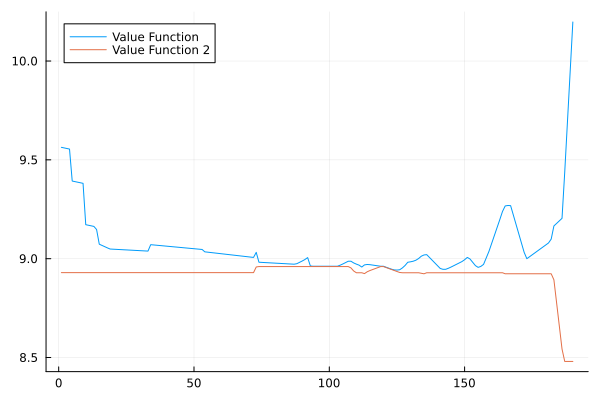

In [61]:
node=model2.nodes[1]
ind=1:1:190
TV=[SDDP.compute_TV(node, Dict(Symbol("volume[1]")=>1.0*i)) for i in ind]
TV_k=[SDDP.compute_approx_TV(node.value_function, Dict(Symbol("volume[1]")=>1.0*i)) for i in ind]
V=[SDDP.compute_V(node.value_function, Dict(Symbol("volume[1]")=>1.0*i)) for i in ind]
plot(ind, TV-V, label="Value Function")
plot!(ind, TV_k-V, label="Value Function 2")
# plot!(ind, TV-TV_k, label="Value Function 2")

# minimum(TV-V)
# findmin(V)

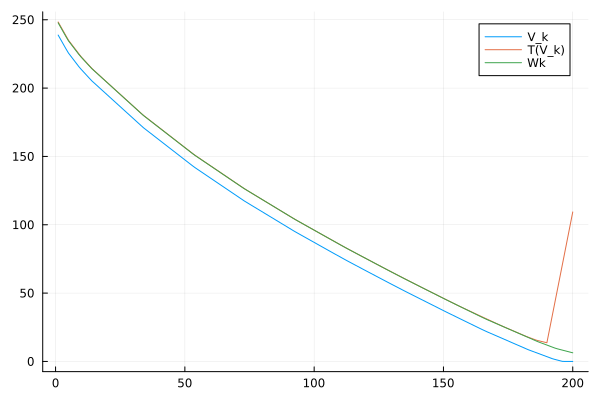

In [64]:
node=model2.nodes[1]
ind=1:200
TV=[SDDP.compute_TV(node, Dict(Symbol("volume[1]")=>1.0*i)) for i in ind]
TV_k=[SDDP.compute_approx_TV(node.value_function, Dict(Symbol("volume[1]")=>1.0*i)) for i in ind]
V=[SDDP.compute_V(node.value_function, Dict(Symbol("volume[1]")=>1.0*i)) for i in ind]
plot(ind, V, label="V_k")
plot!(ind, TV, label="T(V_k)")
plot!(ind, TV_k, label="Wk")

# TV[200]-11.5, V1[200]

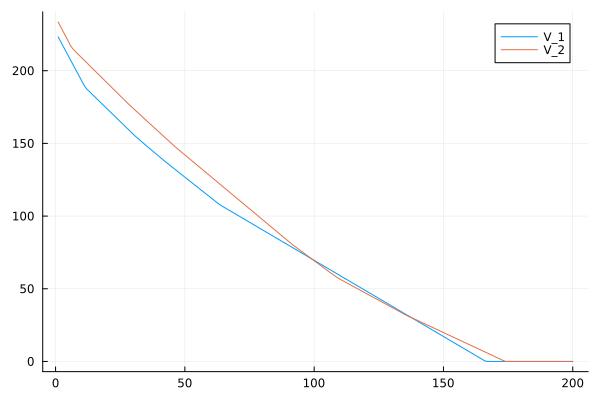

In [23]:
ind=1:200
node=model1.nodes[1]
V1=[SDDP.compute_V(node.value_function, Dict(Symbol("volume[1]")=>1.0*i)) for i in ind]
node=model2.nodes[1]
V2=[SDDP.compute_V(node.value_function, Dict(Symbol("volume[1]")=>1.0*i)) for i in ind]
plot(ind, V1, label="V_1")
plot!(ind, V2, label="V_2")

(-1.8628249402599786, 244.20282075801424, 9.015444171749323)
(-1.685243975546781, 209.29655947821448, 29.015444171749323)
(-1.5625039346837801, 176.9874249543332, 49.01544417174932)
(-1.4497538851962768, 146.73969040103512, 69.01544417174932)
(-1.3506134439691824, 118.84713059420284, 89.01544417174932)
(-1.4551021306371548, 146.82234813475952, 69.01544417174932)
(-1.3506134439691824, 118.84713059420284, 89.01544417174932)
(-1.4551021306371548, 146.91573526921047, 69.01544417174932)
(-1.356712389324278, 118.8766736432484, 89.01544417174932)
(-1.2576282018749023, 92.87545562395991, 109.01544417174932)
(-1.1654571457240444, 68.65021768239963, 129.01544417174932)
(-1.2606746250797727, 92.91445897981978, 109.01544417174932)
(-1.1654571457240444, 68.65021768239963, 129.01544417174932)
(-1.066190010727748, 46.2269015259336, 149.01544417174932)
(-1.1654571457240444, 68.65021768239963, 129.01544417174932)
(-1.0829967866122958, 46.23749594285708, 149.01544417174932)
(-0.9400803083403482, 26.0238

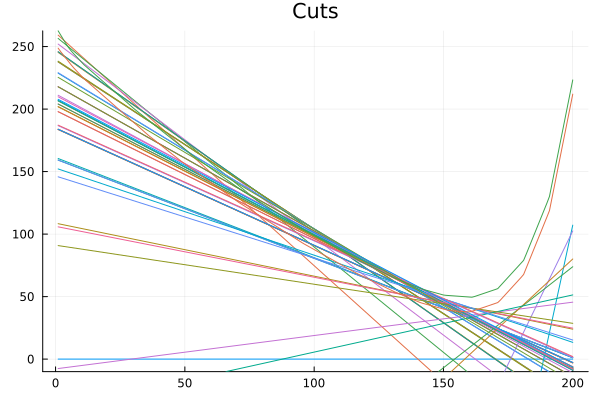

In [301]:
plot(ind, [0 for i in ind], ylims=(-10, :auto), legend = false)
node=1
for c in Cuts1[end-4:end-4]
    cnode=c.iter_cuts[node]
    for i in 1:length(cnode)
        theta=cnode[i][1]
        a=cnode[i][2][Symbol("volume[1]")]
        x_k=cnode[i][3][Symbol("volume[1]")]
        println((a, theta, x_k))
        plot!(ind, [a*(i-x_k)+theta for i in ind])
    end
end
# plot!(1:200, Th)
plot!(ind, V, label="Value Function")
plot!(ind, TV_k, label="Value Function")

title!("Cuts")

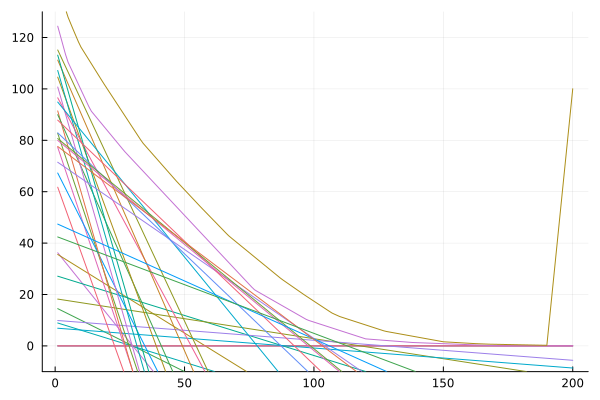

In [510]:
plot(ind, [0 for i in ind], ylims=(-10, 130), legend = false)
Cut=model2[1].value_function.cut_V
for c in Cut[1:end]
    theta=c.intercept
    a=c.coefficients[Symbol("volume[1]")]
    # println(c.shift)
    plot!(ind, [a*i+theta+0*max(0,(c.shift-2.06)) for i in ind])
end
# plot!(1:200, Th)
plot!(ind, V, label="Value Function")
# plot!(ind, TV_k, label="Value Function")
plot!(ind, TV, label="Value Function")

# title!("Cuts")
# Cut[7:end]

In [414]:
model1[1].value_function.cut_V[10:15]

6-element Vector{SDDP.Cut2}:
 SDDP.Cut2(0.0, Dict(Symbol("volume[1]") => 0.0), 0.0, V >= 0, V_1 >= 0)
 SDDP.Cut2(32.5, Dict(Symbol("volume[1]") => -2.5), 0.0, V + 2.5 volume[1]_out >= 32.5, 2.5 volume[1]_out + V_1 >= 32.5)
 SDDP.Cut2(38.0, Dict(Symbol("volume[1]") => -1.0), 0.0, V + volume[1]_out >= 38, volume[1]_out + V_1 >= 38)
 SDDP.Cut2(47.967, Dict(Symbol("volume[1]") => -0.9995), 0.0, V + 0.9995 volume[1]_out >= 47.967, 0.9995 volume[1]_out + V_1 >= 47.967)
 SDDP.Cut2(38.937023999999994, Dict(Symbol("volume[1]") => -0.49925025), 0.0, V + 0.49925025 volume[1]_out >= 38.937023999999994, 0.49925025 volume[1]_out + V_1 >= 38.937023999999994)
 SDDP.Cut2(55.89231248924999, Dict(Symbol("volume[1]") => -0.748625749875), 0.0, V + 0.748625749875 volume[1]_out >= 55.89231248924999, 0.748625749875 volume[1]_out + V_1 >= 55.89231248924999)

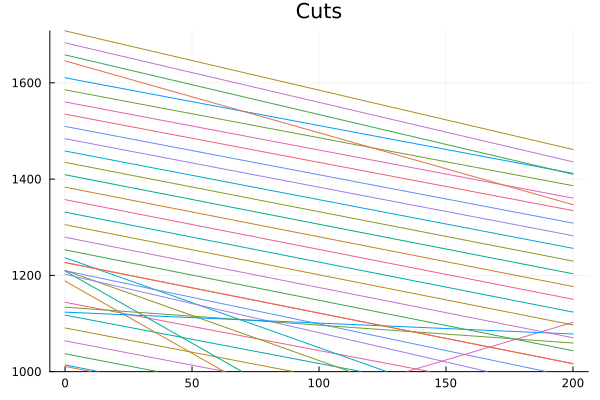

In [ ]:
plot(ind, [0 for i in ind], ylims=(1000, :auto), legend = false)
node=3
for c in Cuts1[end-99:end-90]
    cnode=c.iter_cuts[node]
    for i in 1:length(cnode)
        theta=cnode[i][1]
        a=cnode[i][2][Symbol("volume[1]")]
        x_k=cnode[i][3][Symbol("volume[1]")]
        # println((a, theta, x_k))
        plot!(ind, [a*(i-x_k)+theta for i in ind])
    end
end
# plot!(1:200, Th)

title!("Cuts")

# savefig("figure.png")

In [207]:
model2[1].value_function.cut_V

211-element Vector{SDDP.Cut2}:
 SDDP.Cut2(0.0, Dict(Symbol("volume[1]") => 0.0))
 SDDP.Cut2(0.0, Dict(Symbol("volume[1]") => 0.0))
 SDDP.Cut2(0.0, Dict(Symbol("volume[1]") => 0.0))
 SDDP.Cut2(0.0, Dict(Symbol("volume[1]") => 0.0))
 SDDP.Cut2(10.0, Dict(Symbol("volume[1]") => -1.0))
 SDDP.Cut2(0.0, Dict(Symbol("volume[1]") => 0.0))
 SDDP.Cut2(0.0, Dict(Symbol("volume[1]") => 0.0))
 SDDP.Cut2(0.0, Dict(Symbol("volume[1]") => 0.0))
 SDDP.Cut2(0.0, Dict(Symbol("volume[1]") => 0.0))
 SDDP.Cut2(0.0, Dict(Symbol("volume[1]") => 0.0))
 ⋮
 SDDP.Cut2(213.54636894000487, Dict(Symbol("volume[1]") => -1.7409800656114658))
 SDDP.Cut2(209.35735456663824, Dict(Symbol("volume[1]") => -1.539007561829066))
 SDDP.Cut2(218.82702379949185, Dict(Symbol("volume[1]") => -2.508786335508392))
 SDDP.Cut2(218.82702379949185, Dict(Symbol("volume[1]") => -2.508786335508392))
 SDDP.Cut2(205.06648444069808, Dict(Symbol("volume[1]") => -1.4049497352959912))
 SDDP.Cut2(197.53254309763145, Dict(Symbol("volume[1]") => -1.